# NBA Winner Classifier

## Imports

In [472]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
#pd.options.display.max_columns = None
#pd.set_option("display.max_colwidth", None)
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
#pd.set_option("display.max_rows", None)
import model.train as train
import model.config as model_config
import utils
import model.dataset.season_game as sg
import utils_nba_winner_clf as utils_exp
import qgrid
from yellowbrick import classifier, features
from pandas_profiling import ProfileReport

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.compose import ColumnTransformer
from boruta import BorutaPy
from collections import defaultdict
from sklearn.ensemble import RandomForestClassifier

## Setup

In [473]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
%autosave 60

sns.set(style="whitegrid")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Autosaving every 60 seconds


### Utils functions

In [474]:
def filter_from(items, cond):
    return list(filter(cond, items))

In [475]:
def del_result_by(exp_name):
    global results_total
    results_total = filter_from(results_total, lambda i: i[0] != exp_name)
    utils_exp.exp_results = filter_from(utils_exp.exp_results, lambda i: i['exp_name'] != exp_name)

In [476]:
def get_result_by(exp_name):
    global results_total
    return next((x for x in results_total if x[0] == exp_name), None)

In [25]:
#del_result_by('reg_1_season')
#utils_exp.exp_results
#utils.deserialize_object(f'result_totals', [])

In [477]:
def show_qgrid(df_):
    qgrid_widget = qgrid.show_grid(df_, show_toolbar=True , grid_options={'forceFitColumns': False, 'defaultColumnWidth': 200})
    qgrid_widget

In [478]:
def plot_results(experiment_name, results, figsize=(20,10)):
    plt.figure(figsize=figsize)
    results_df = utils.map_results_to_df(results)
    a = sns.lineplot(
        data=results_df,
        x="season_test", y="prec", hue="model", style="model",
        markers=True, dashes=False)
    a.set_title(
        f"{experiment_name}-prec")
    a.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

In [479]:
def get_results_df():
    return pd.DataFrame(utils_exp.exp_results)

In [480]:
metrics = ['prec', 'bal_acc', 'roc_auc']

def print_prettier_exp_results(exp_name, metric='prec', filter_val=None):
    second_metric = 'bal_acc' if metric == 'prec' else 'prec'
    ba_df = get_results_df()[['exp_name', 'model',
       f'{metric}_mean', f'{metric}_std', f'{second_metric}_mean', f'{second_metric}_std']]
    cond = ba_df.exp_name == exp_name
    if filter_val is not None:
        cond = (ba_df.exp_name == exp_name) & (ba_df.model.isin(filter_val))
    return ba_df[cond].sort_values(by=[f"{metric}_mean"], ascending=False)

## Load Dataset

In [481]:
season_games = sg.load_season_games_dataset()

## Dataset


In [179]:
season_games.groupby(by="SEASON").count()["GAME_DATE_EST"]

SEASON
2002    1189
2003    1189
2004    1230
2005    1230
2006    1230
2007    1230
2008    1230
2009    1230
2010    1230
2011     990
2012    1229
2013    1230
2014    1230
2015    1230
2016    1230
2017    1230
2018    1230
2019    1059
Name: GAME_DATE_EST, dtype: int64

Podemos observar que no todas las temporadas tiene la misma cantidad de partidos. Esto es debido a la siguientes razones:

- 2011: Los jugadores hicieron una huelga debido a no estar de acuerdo con los salarios de los mismos y el limite salarial de las franquicias.
- 2012: Un partido entre el equipo de Boston e Indiana fue suspedindo el cual despues no fue reprogramado, y al final de la temporada se decidio ya no reprogramarlo debido a que la clasificacion a playoff ya estaba decidida y no afectaba el resultado.

Por tanto se seleccionaran solo las temporadas a partir del 2013(inclusive).

In [482]:
df = season_games[(season_games.SEASON >= 2010) & (season_games.SEASON <= 2017)]
seasons_size = len(df.SEASON.unique())
seasons = list(df.SEASON.unique())

In [483]:
print(df.shape)
df = df.dropna()
print(df.isnull().sum().sum())
print(df.shape)

(9599, 405)
0
(9461, 405)


In [182]:
df[df.SEASON >= 2012]

SEASON_ID  TEAM_ID_HOME TEAM_ABBREVIATION_HOME  \
GAME_ID                                                     
0021200019     22012    1610612739                    CLE   
0021200021     22012    1610612740                    NOH   
0021200022     22012    1610612760                    OKC   
0021200024     22012    1610612756                    PHX   
0021200025     22012    1610612747                    LAL   
...              ...           ...                    ...   
0021701226     22017    1610612740                    NOP   
0021701227     22017    1610612760                    OKC   
0021701228     22017    1610612746                    LAC   
0021701229     22017    1610612757                    POR   
0021701230     22017    1610612758                    SAC   

                    TEAM_NAME_HOME  GAME_DATE MATCHUP_HOME WL_HOME  MIN_HOME  \
GAME_ID                                                                        
0021200019     Cleveland Cavaliers 2012-11-02  CLE vs. CHI       L       240   
0021200021     New Orleans Hornets 2012-11-02  NOH vs. UTA       W       240   
0021200022   Oklahoma City Thunder 2012-11-02  OKC vs. POR       W       240   
0021200024            Phoenix Suns 2012-11-02  PHX vs. DET       W       240   
0021200025      Los Angeles Lakers 2012-11-02  LAL vs. LAC       L       240   
...                            ...        ...          ...     ...       ...   
0021701226    New Orleans Pelicans 2018-04-11  NOP vs. SAS       W       240   
0021701227   Oklahoma City Thunder 2018-04-11  OKC vs. MEM       W       240   
0021701228             LA Clippers 2018-04-11  LAC vs. LAL       L       240   
0021701229  Portland Trail Blazers 2018-04-11  POR vs. UTA       W       240   
0021701230        Sacramento Kings 2018-04-11  SAC vs. HOU       W       240   

            FGM_HOME  FGA_HOME  ...  HOME_FT_MEAN  HOME_FT_MEAN_L10  \
GAME_ID                         ...                                   
0021200019        32        79  ...     -0.075758         -0.075758   
0021200021        37        81  ...      0.174948          0.174948   
0021200022        39        76  ...      0.004658          0.004658   
0021200024        40        92  ...      0.003497          0.003497   
0021200025        34        68  ...     -0.086481         -0.086481   
...              ...       ...  ...           ...               ...   
0021701226        52        88  ...      0.001313          0.061021   
0021701227        47        85  ...     -0.068136         -0.002186   
0021701228        41        83  ...      0.034199         -0.056352   
0021701229        41        89  ...      0.022644          0.077753   
0021701230        38        80  ...     -0.044865         -0.010244   

            HOME_FT_MEAN_ML10  HOME_FG_AGAINST_MEAN  HOME_FG_AGAINST_MEAN_L10  \
GAME_ID                                                                         
0021200019          -0.022035             -0.049206                 -0.049206   
0021200021          -0.007347              0.098529                  0.098529   
0021200022           0.025397             -0.056962                 -0.056962   
0021200024           0.011693             -0.109950                 -0.109950   
0021200025           0.009874              0.104374                  0.104374   
...                       ...                   ...                       ...   
0021701226          -0.014363              0.003473                 -0.015727   
0021701227          -0.085776             -0.003191                 -0.005758   
0021701228           0.105209              0.002227                  0.038371   
0021701229          -0.003832             -0.001423                  0.011659   
0021701230          -0.060693              0.009010                  0.016306   

            HOME_FG3_AGAINST_MEAN  HOME_FG3_AGAINST_MEAN_L10  \
GAME_ID                                                        
0021200019              -0.102941                  -0.102941   
002120

In [484]:
df.drop(df[df.G_PLAYED < 20].index, inplace = True)
print(df.shape)

(8372, 405)


In [485]:
utils.serialize_object('df', df)

## Experiments

### Setup

In [486]:
X_features = model_config.X_COLS_BEST_BORUTA

In [487]:
exp_prefix = "clf_"
#exp_group_name = "clf_experiments"
exp_group_name = "clf_experiments_boruta"
results_total = utils.deserialize_object(f'result_totals_{exp_group_name}', [])
utils_exp.exp_results = []
TARGET = "HOME_WINS"

exp_X_columns = X_features
exp_y_columns = model_config.Y_CLF_COL

models = utils_exp.get_clf_models()

sscv = utils.SeasonSeriesSplit(df)
df_sscv = sscv.get_df()
X = df_sscv[exp_X_columns]
y = df_sscv[TARGET]

### Feature selection

In [488]:
def dict_to_list(d):
    dictlist = []
    for key, value in d.items():
        temp = [key,value]
        dictlist.append(temp)
    return pd.DataFrame(data=dictlist)

In [217]:
## RandomForest
model = RandomForestClassifier(n_jobs=-1, class_weight='balanced', max_depth=5)

x_cols = model_config.X_COLS_NO_HIGH_CORR
folds, train_seasons, test_seasons = sscv.split(train_size=2, test_size=1)
X_boruta = df_sscv[x_cols]
y_boruta = df_sscv[TARGET]

folds_selected_features = defaultdict(int)
boruta_selector = BorutaPy(model, n_estimators = 500, max_iter=200, random_state = 0)
list_selected_features = []

for train_idx, test_idx in folds[-3:]:    
    X_train, X_test = X_boruta.loc[train_idx], X_boruta.loc[test_idx]
    y_train, y_test = y_boruta.loc[train_idx], y_boruta.loc[test_idx]
    y_true = y_test
    # fit boruta
    boruta_selector.fit(np.array(X_train), np.array(y_train))
    boruta_ranking = boruta_selector.ranking_
    selected_features = np.array(x_cols)[boruta_ranking <= 2]
    list_selected_features.append(selected_features)
    for f in selected_features:
        folds_selected_features[f]+=1
#dict_to_list(folds_selected_features)
# # store results
# boruta_ranking = boruta_selector.ranking_
# selected_features = np.array(feature_names)[boruta_ranking <= 2]

KeyboardInterrupt: 

In [ ]:
f_df = dict_to_list(folds_selected_features)

In [ ]:
f_df.sort_values(by=[1, 0], ascending=False)
final_selected_features = f_df[f_df[1] > 1][0].unique()
#final_selected_features = list(f_df[0].unique())

In [ ]:
# best_boruta = list_selected_features[3]
# sorted(best_boruta)
# best_boruta
sorted(final_selected_features)
#final_selected_features
final_selected_features = \
[
 'BLK_MEAN_HOME',
 'BLK_MEAN_AWAY',
 'FG3_PCT_MEAN_HOME',
 'FG3_PCT_MEAN_AWAY',
 'FG_PCT_MEAN_AWAY',
 'FG_PCT_MEAN_HOME',
 'HOME_AST_L10',
 'HOME_AST_MEAN',
 'HOME_AST_ML10',
 'HOME_FG3_PCT_MEAN',
 'HOME_FG_PCT_L10',
 'HOME_FG_PCT_MEAN',
 'HOME_FG_PCT_ML10',
 'HOME_PF_MEAN',
 'HOME_PLUS_MINUS_L10',
 'HOME_PLUS_MINUS_MEAN',
 'HOME_PLUS_MINUS_ML10',
 'HOME_PTS_L10',
 'HOME_PTS_MEAN',
 'HOME_PYTHAGOREAN_EXPECTATION',
 'HOME_PYTHAGOREAN_EXPECTATION_CUM_ML10',
 'HOME_PYTHAGOREAN_EXPECTATION_L10',
 'HOME_REB_MEAN',
 'PLUS_MINUS_L10_AWAY',
 'PLUS_MINUS_L10_HOME',
 'PLUS_MINUS_MEAN_AWAY',
 'PLUS_MINUS_MEAN_HOME',
 'PTS_MEAN_AWAY',
 'PTS_MEAN_HOME',
 'PTS_ML10_HOME',
 'PTS_ML10_AWAY'
]

#### Test best features

In [ ]:
for idx, features in enumerate(list_selected_features):
    X_boruta = df_sscv[features]
    y_boruta = df_sscv[TARGET]
    models = utils_exp.get_clf_models()

    experiment_name = f"{exp_prefix}2_seasons_boruta_{idx}"
    del_result_by(experiment_name)
    folds, train_seasons, test_seasons = sscv.split(train_size=2, test_size=1)


    params = (experiment_name, models, folds, train_seasons, test_seasons, X_boruta, y_boruta)
    names, results = utils_exp.run_experiment(*params)
    results_total.append((experiment_name, results))

In [121]:
# #### Visualize experiments results
# name, res = get_result_by(experiment_name)
# plot_results(name, res, figsize=(8,8))
exp_df = get_results_df()
qgrid_widget = qgrid.show_grid(exp_df, show_toolbar=True , grid_options={'forceFitColumns': False, 'defaultColumnWidth': 200})
qgrid_widget
#exp_df.sort_values(by=["bal_acc_mean"], ascending=False)

QgridWidget(grid_options={'fullWidthRows': True, 'syncColumnCellResize': True, 'forceFitColumns': False, 'defa…

#### Test specific best feature set

In [16]:
#features = list_selected_features[5]
features = model_config.X_COLS_NO_HIGH_CORR
X_boruta = df_sscv[features]
y_boruta = df_sscv[TARGET]
models = utils_exp.get_clf_models()

experiment_name = f"{exp_prefix}2_seasons_boruta_fsf"
del_result_by(experiment_name)
folds, train_seasons, test_seasons = sscv.split(train_size=2, test_size=1)


params = (experiment_name, models, folds, train_seasons, test_seasons, X_boruta, y_boruta)
names, results = utils_exp.run_experiment(*params)
results_total.append((experiment_name, results))
print_prettier_exp_results(experiment_name)

Running experiment clf_2_seasons_boruta_fsf
Done


exp_name model  prec_mean  prec_std  bal_acc_mean  \
1  clf_2_seasons_boruta_fsf   KNN   0.681999  0.023866      0.624220   
4  clf_2_seasons_boruta_fsf    RF   0.676674  0.020242      0.627080   
3  clf_2_seasons_boruta_fsf   SVM   0.675359  0.029767      0.625867   
0  clf_2_seasons_boruta_fsf   L2R   0.674783  0.027254      0.626146   
5  clf_2_seasons_boruta_fsf   XGB   0.656815  0.019491      0.599434   
6  clf_2_seasons_boruta_fsf   LGB   0.656575  0.019315      0.599821   
2  clf_2_seasons_boruta_fsf    DT   0.629300  0.008158      0.553703   

   bal_acc_std  
1     0.020390  
4     0.019150  
3     0.028115  
0     0.024149  
5     0.014473  
6     0.014880  
2     0.009309

#### Test custom best feature set

In [254]:
X_COLS_BEST_BORUTA = ['FG_PCT_MEAN_AWAY',
                      'FG_PCT_MEAN_HOME',
                      'FT_PCT_ML10_AWAY',
                      'HOME_FG3_PCT',
                      'HOME_FG_PCT_L10',
                      'HOME_FG_PCT_MEAN',
                      'HOME_FT_PCT',
                      'HOME_FT_PCT_ML10',
                      'HOME_PLUS_MINUS_L10',
                      'HOME_PLUS_MINUS_MEAN',
                      'HOME_PLUS_MINUS_ML10',
                      'PLUS_MINUS_L10_AWAY',
                      'PLUS_MINUS_L10_HOME',
                      'PLUS_MINUS_MEAN_AWAY',
                      'PLUS_MINUS_MEAN_HOME',
                      'W_L_CUM_AWAY',
                      'W_L_CUM_HOME']
X_boruta = df_sscv[X_COLS_BEST_BORUTA]
y_boruta = df_sscv[TARGET]

experiment_name = f"{exp_prefix}2_seasons_boruta_custom"
del_result_by(experiment_name)
folds, train_seasons, test_seasons = sscv.split(train_size=2, test_size=1)

params = (experiment_name, models, folds, train_seasons, test_seasons, X_boruta, y_boruta)
names, results = utils_exp.run_experiment(*params)
results_total.append((experiment_name, results))
print_prettier_exp_results(experiment_name)

Running experiment clf_2_seasons_boruta_custom
Done


exp_name model  precision_mean  precision_std
73  clf_2_seasons_boruta_custom   SVM        0.760366       0.011854
70  clf_2_seasons_boruta_custom    LR        0.760026       0.011737
74  clf_2_seasons_boruta_custom    RF        0.755667       0.010853
75  clf_2_seasons_boruta_custom   XGB        0.748373       0.005121
76  clf_2_seasons_boruta_custom   LGB        0.743551       0.005716
72  clf_2_seasons_boruta_custom    DT        0.697575       0.008015
71  clf_2_seasons_boruta_custom   KNN        0.684097       0.016000

### Experiment using 1 season

In [490]:
experiment_name = f"{exp_prefix}1_season"

In [491]:
del_result_by(experiment_name)

folds, train_seasons, test_seasons = sscv.split(train_size=1, test_size=1)
params = (experiment_name, models, folds, train_seasons, test_seasons, X, y)
names, results = utils_exp.run_experiment(*params)
results_total.append((experiment_name, results))

print_prettier_exp_results(experiment_name)

Running experiment clf_1_season
Done


exp_name model  prec_mean  prec_std  bal_acc_mean  bal_acc_std
0  clf_1_season   L2R   0.687839  0.027481      0.641971     0.021729
1  clf_1_season   KNN   0.686292  0.027186      0.627032     0.019635
3  clf_1_season   SVM   0.684745  0.028484      0.640279     0.025756
4  clf_1_season    RF   0.677507  0.023956      0.625129     0.019909
6  clf_1_season   XGB   0.663264  0.026672      0.603988     0.018580
5  clf_1_season   LGB   0.660524  0.021259      0.601526     0.014291
2  clf_1_season    DT   0.638760  0.027354      0.565558     0.019602

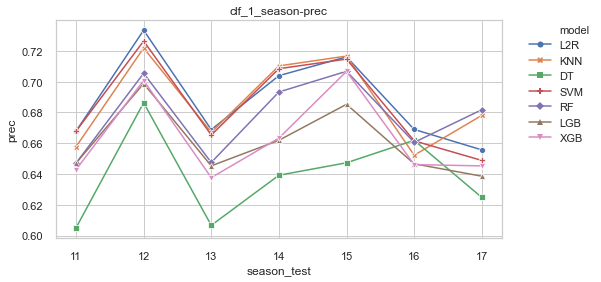

In [492]:
#### Visualize experiments results
name, res = get_result_by(experiment_name)
plot_results(name, res, figsize=(8,4))

In [493]:
utils.folds_to_df(folds, train_seasons, test_seasons)

train_seasons  train_samples_size test_seasons  test_samples_size
0            10                1077           11                838
1            11                 838           12               1078
2            12                1078           13               1076
3            13                1076           14               1075
4            14                1075           15               1076
5            15                1076           16               1075
6            16                1075           17               1077

### Experiment using StandardScaler

In [494]:
experiment_name = f"{exp_prefix}scaled_data"

In [495]:
del_result_by(experiment_name)

num_pipeline = Pipeline([
    ('std_scaler', StandardScaler())
])
preprocessor = ColumnTransformer([
        ('numerical', num_pipeline, exp_X_columns)
    ], remainder='passthrough')
#transformed_data = preprocessor.fit_transform(df)

folds, train_seasons, test_seasons = sscv.split(train_size=1, test_size=1)
params = (experiment_name, models, folds, train_seasons, test_seasons, X, y, preprocessor)
names, results = utils_exp.run_experiment(*params)
results_total.append((experiment_name, results))

print_prettier_exp_results(experiment_name)

Running experiment clf_scaled_data
Done


exp_name model  prec_mean  prec_std  bal_acc_mean  bal_acc_std
8   clf_scaled_data   KNN   0.685084  0.023136      0.628981     0.015091
7   clf_scaled_data   L2R   0.678465  0.031574      0.629401     0.025584
11  clf_scaled_data    RF   0.677148  0.023549      0.624887     0.019295
10  clf_scaled_data   SVM   0.675187  0.031232      0.623547     0.025851
13  clf_scaled_data   XGB   0.662965  0.026753      0.603566     0.018779
12  clf_scaled_data   LGB   0.659629  0.020667      0.601216     0.015494
9   clf_scaled_data    DT   0.639025  0.027258      0.565930     0.019381

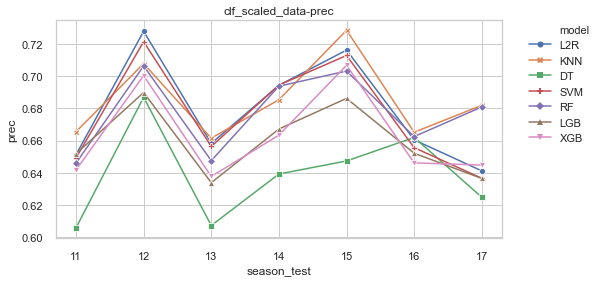

In [496]:
#### Visualize experiments results
name, res = get_result_by(experiment_name)
plot_results(name, res, figsize=(8,4))


In [497]:
utils.folds_to_df(folds, train_seasons, test_seasons)

train_seasons  train_samples_size test_seasons  test_samples_size
0            10                1077           11                838
1            11                 838           12               1078
2            12                1078           13               1076
3            13                1076           14               1075
4            14                1075           15               1076
5            15                1076           16               1075
6            16                1075           17               1077

### Experiment using MinMaxScaler

In [498]:
experiment_name = f"{exp_prefix}minmax_data"

In [499]:
del_result_by(experiment_name)

num_pipeline = Pipeline([
    ('minmax_scaler', MinMaxScaler())
])
preprocessor = ColumnTransformer([
        ('numerical', num_pipeline, exp_X_columns)
    ], remainder='passthrough')
#transformed_data = preprocessor.fit_transform(df)

folds, train_seasons, test_seasons = sscv.split(train_size=1, test_size=1)
params = (experiment_name, models, folds, train_seasons, test_seasons, X, y, preprocessor)
names, results = utils_exp.run_experiment(*params)
results_total.append((experiment_name, results))

print_prettier_exp_results(experiment_name)

Running experiment clf_minmax_data
Done


exp_name model  prec_mean  prec_std  bal_acc_mean  bal_acc_std
15  clf_minmax_data   KNN   0.682954  0.022674      0.626513     0.014289
14  clf_minmax_data   L2R   0.678868  0.028794      0.631400     0.022710
17  clf_minmax_data   SVM   0.678272  0.031224      0.628883     0.025933
18  clf_minmax_data    RF   0.677764  0.024039      0.625585     0.020162
20  clf_minmax_data   XGB   0.663193  0.026923      0.603852     0.018701
19  clf_minmax_data   LGB   0.659017  0.026571      0.600312     0.017096
16  clf_minmax_data    DT   0.638651  0.027489      0.565409     0.019814

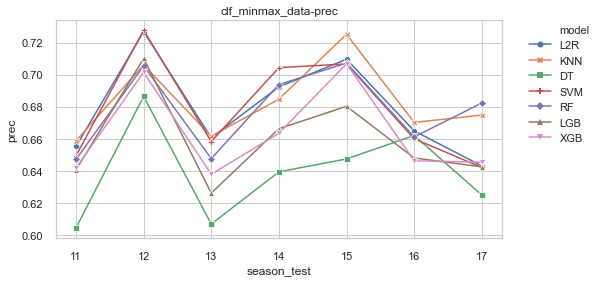

In [500]:
#### Visualize experiments results
name, res = get_result_by(experiment_name)
plot_results(name, res, figsize=(8,4))

In [501]:
utils.folds_to_df(folds, train_seasons, test_seasons)

train_seasons  train_samples_size test_seasons  test_samples_size
0            10                1077           11                838
1            11                 838           12               1078
2            12                1078           13               1076
3            13                1076           14               1075
4            14                1075           15               1076
5            15                1076           16               1075
6            16                1075           17               1077

### Experiment: train: 2s; test: 1s

In [502]:
experiment_name = f"{exp_prefix}2_seasons"

In [503]:
del_result_by(experiment_name)

folds, train_seasons, test_seasons = sscv.split(train_size=2, test_size=1)
params = (experiment_name, models, folds, train_seasons, test_seasons, X, y)
names, results = utils_exp.run_experiment(*params)
results_total.append((experiment_name, results))

print_prettier_exp_results(experiment_name)



Running experiment clf_2_seasons
Done


exp_name model  prec_mean  prec_std  bal_acc_mean  bal_acc_std
24  clf_2_seasons   SVM   0.692746  0.045406      0.636687     0.031548
22  clf_2_seasons   KNN   0.692207  0.021471      0.631198     0.021358
21  clf_2_seasons   L2R   0.690337  0.020950      0.643317     0.018413
25  clf_2_seasons    RF   0.685711  0.014992      0.633128     0.014196
26  clf_2_seasons   LGB   0.673562  0.022517      0.614078     0.021189
27  clf_2_seasons   XGB   0.668443  0.022435      0.608833     0.021853
23  clf_2_seasons    DT   0.654047  0.022181      0.581493     0.023785

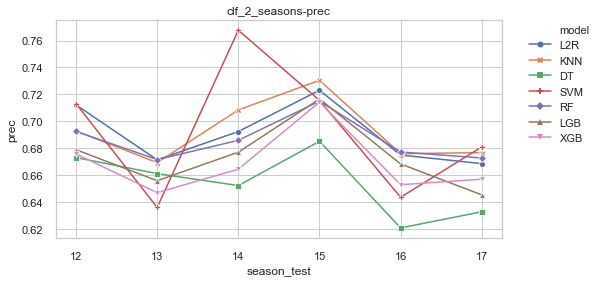

In [504]:
#### Visualize experiments results
name, res = get_result_by(experiment_name)
plot_results(name, res, figsize=(8,4))

In [505]:
utils.folds_to_df(folds, train_seasons, test_seasons)

train_seasons  train_samples_size test_seasons  test_samples_size
0         10-11                1915           12               1078
1         11-12                1916           13               1076
2         12-13                2154           14               1075
3         13-14                2151           15               1076
4         14-15                2151           16               1075
5         15-16                2151           17               1077

### Experiment: train: 3s; test: 1s

In [506]:
experiment_name = f"{exp_prefix}3_seasons"

In [507]:
del_result_by(experiment_name)

folds, train_seasons, test_seasons = sscv.split(train_size=3, test_size=1)
params = (experiment_name, models, folds, train_seasons, test_seasons, X, y)
names, results = utils_exp.run_experiment(*params)
results_total.append((experiment_name, results))

print_prettier_exp_results(experiment_name)

Running experiment clf_3_seasons
Done


exp_name model  prec_mean  prec_std  bal_acc_mean  bal_acc_std
31  clf_3_seasons   SVM   0.688588  0.031502      0.644895     0.025889
29  clf_3_seasons   KNN   0.688542  0.018917      0.633994     0.019718
28  clf_3_seasons   L2R   0.686870  0.017954      0.644777     0.019230
32  clf_3_seasons    RF   0.683999  0.021817      0.637553     0.022627
34  clf_3_seasons   XGB   0.674493  0.014658      0.621336     0.016321
33  clf_3_seasons   LGB   0.672144  0.016514      0.620827     0.012818
30  clf_3_seasons    DT   0.649614  0.024351      0.581571     0.024469

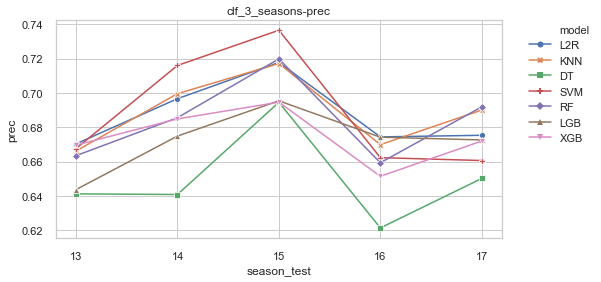

In [508]:
#### Visualize experiments results
name, res = get_result_by(experiment_name)
plot_results(name, res, figsize=(8,4))

In [509]:
utils.folds_to_df(folds, train_seasons, test_seasons)

train_seasons  train_samples_size test_seasons  test_samples_size
0      10-11-12                2993           13               1076
1      11-12-13                2992           14               1075
2      12-13-14                3229           15               1076
3      13-14-15                3227           16               1075
4      14-15-16                3226           17               1077

### Experiment train: 2q ; test: 2q

In [510]:
experiment_name = f"{exp_prefix}2q_2q"

In [511]:
del_result_by(experiment_name)

folds, train_seasons, test_seasons = sscv.quarter_split(train_size=2, test_size=2)
params = (experiment_name, models, folds, train_seasons, test_seasons, X, y)
names, results = utils_exp.run_experiment(*params)
results_total.append((experiment_name, results))

print_prettier_exp_results(experiment_name)

Running experiment clf_2q_2q
Done


exp_name model  prec_mean  prec_std  bal_acc_mean  bal_acc_std
36  clf_2q_2q   KNN   0.687164  0.048761      0.630017     0.026744
35  clf_2q_2q   L2R   0.684338  0.039926      0.635334     0.029214
39  clf_2q_2q    RF   0.678120  0.045223      0.624597     0.030772
38  clf_2q_2q   SVM   0.676023  0.040890      0.625649     0.036190
41  clf_2q_2q   XGB   0.663301  0.032675      0.603181     0.024235
40  clf_2q_2q   LGB   0.656191  0.041259      0.594947     0.027393
37  clf_2q_2q    DT   0.643592  0.027044      0.569224     0.022924

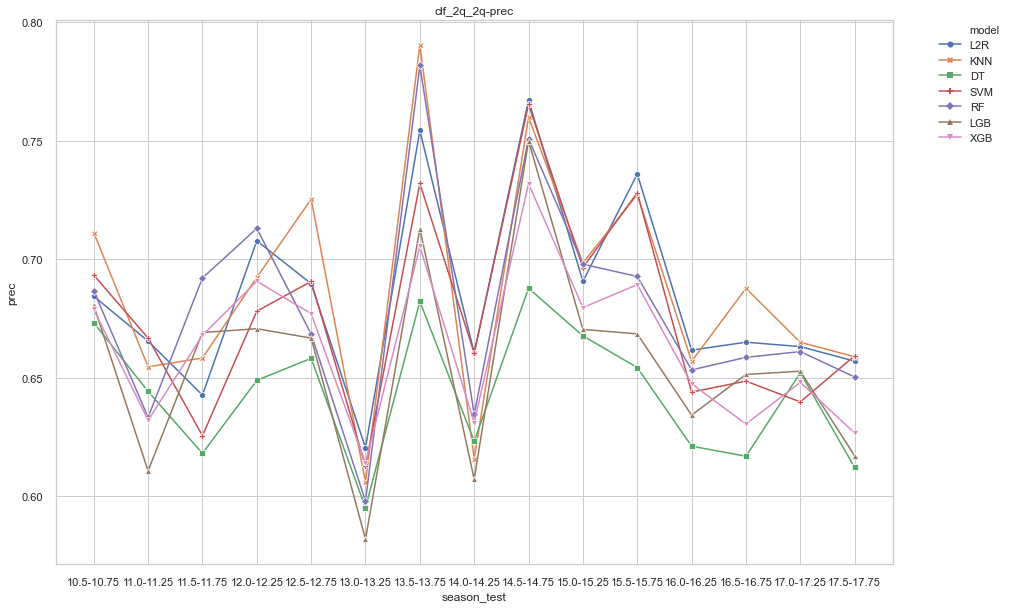

In [512]:
#### Visualize experiments results
name, res = get_result_by(experiment_name)
plot_results(name, res, figsize=(15, 10))

In [513]:
utils.folds_to_df(folds, train_seasons, test_seasons)

train_seasons  train_samples_size test_seasons  test_samples_size
0     10.0-10.25                 538   10.5-10.75                539
1     10.5-10.75                 539   11.0-11.25                419
2     11.0-11.25                 419   11.5-11.75                419
3     11.5-11.75                 419   12.0-12.25                539
4     12.0-12.25                 539   12.5-12.75                539
5     12.5-12.75                 539   13.0-13.25                538
6     13.0-13.25                 538   13.5-13.75                538
7     13.5-13.75                 538   14.0-14.25                537
8     14.0-14.25                 537   14.5-14.75                538
9     14.5-14.75                 538   15.0-15.25                538
10    15.0-15.25                 538   15.5-15.75                538
11    15.5-15.75                 538   16.0-16.25                537
12    16.0-16.25                 537   16.5-16.75                538
13    16.5-16.75                 538   17.0-17.25                538
14    17.0-17.25                 538   17.5-17.75                539

### Experiment remove first 2q ;train: 2q ; test: 2q

In [514]:
experiment_name = f"{exp_prefix}2q_2q_r2q"

In [515]:
del_result_by(experiment_name)

folds, train_seasons, test_seasons = sscv.quarter_split(train_size=2, test_size=2, remove_quarters=[0.25, 0.5])
params = (experiment_name, models, folds, train_seasons, test_seasons, X, y)
names, results = utils_exp.run_experiment(*params)
results_total.append((experiment_name, results))

print_prettier_exp_results(experiment_name)

Running experiment clf_2q_2q_r2q
Done


exp_name model  prec_mean  prec_std  bal_acc_mean  bal_acc_std
43  clf_2q_2q_r2q   KNN   0.704051  0.026709      0.641051     0.020360
46  clf_2q_2q_r2q    RF   0.699660  0.021177      0.639447     0.017709
45  clf_2q_2q_r2q   SVM   0.698467  0.025723      0.646054     0.018770
42  clf_2q_2q_r2q   L2R   0.697795  0.031597      0.642949     0.025091
48  clf_2q_2q_r2q   XGB   0.685198  0.026743      0.619875     0.022233
47  clf_2q_2q_r2q   LGB   0.681862  0.027055      0.616220     0.021901
44  clf_2q_2q_r2q    DT   0.654053  0.019406      0.572988     0.009348

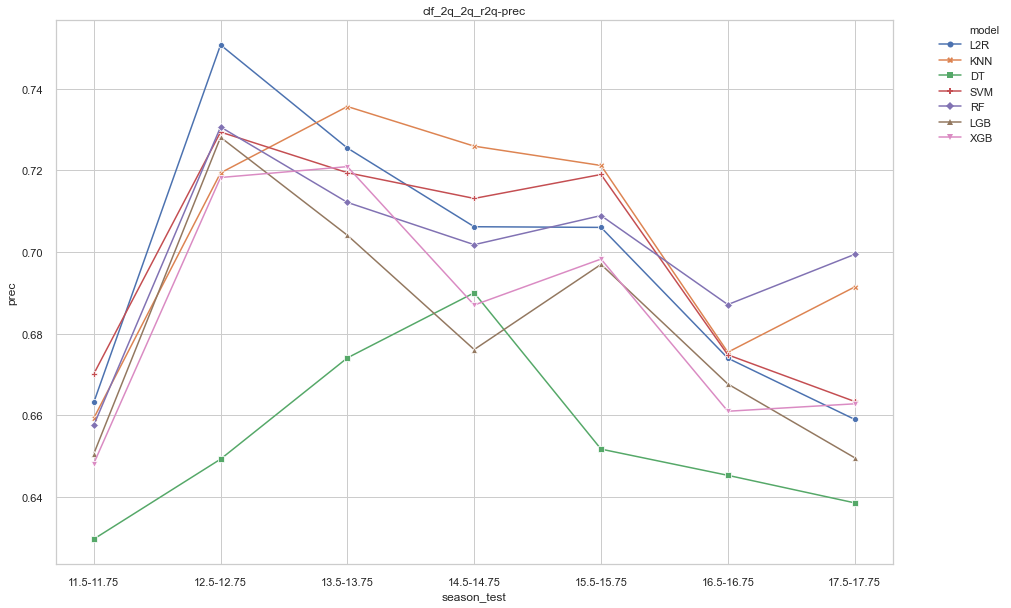

In [516]:
#### Visualize experiments results
name, res = get_result_by(experiment_name)
plot_results(name, res, figsize=(15, 10))

In [517]:
utils.folds_to_df(folds, train_seasons, test_seasons)

train_seasons  train_samples_size test_seasons  test_samples_size
0    10.5-10.75                 539   11.5-11.75                419
1    11.5-11.75                 419   12.5-12.75                539
2    12.5-12.75                 539   13.5-13.75                538
3    13.5-13.75                 538   14.5-14.75                538
4    14.5-14.75                 538   15.5-15.75                538
5    15.5-15.75                 538   16.5-16.75                538
6    16.5-16.75                 538   17.5-17.75                539

### Experiment train: 3q ; test: 1q

In [518]:
experiment_name = f"{exp_prefix}3q_1q"

In [519]:
del_result_by(experiment_name)

folds, train_seasons, test_seasons = sscv.quarter_split(train_size=3, test_size=1)
params = (experiment_name, models, folds, train_seasons, test_seasons, X, y)
names, results = utils_exp.run_experiment(*params)
results_total.append((experiment_name, results))

print_prettier_exp_results(experiment_name)

Running experiment clf_3q_1q
Done


exp_name model  prec_mean  prec_std  bal_acc_mean  bal_acc_std
50  clf_3q_1q   KNN   0.694450  0.048930      0.634392     0.034819
52  clf_3q_1q   SVM   0.692063  0.041997      0.641314     0.032942
49  clf_3q_1q   L2R   0.688457  0.040231      0.640271     0.035652
53  clf_3q_1q    RF   0.682853  0.041359      0.628304     0.033280
54  clf_3q_1q   LGB   0.664860  0.040919      0.602574     0.031403
55  clf_3q_1q   XGB   0.659976  0.039344      0.595616     0.032256
51  clf_3q_1q    DT   0.639792  0.043468      0.563099     0.035199

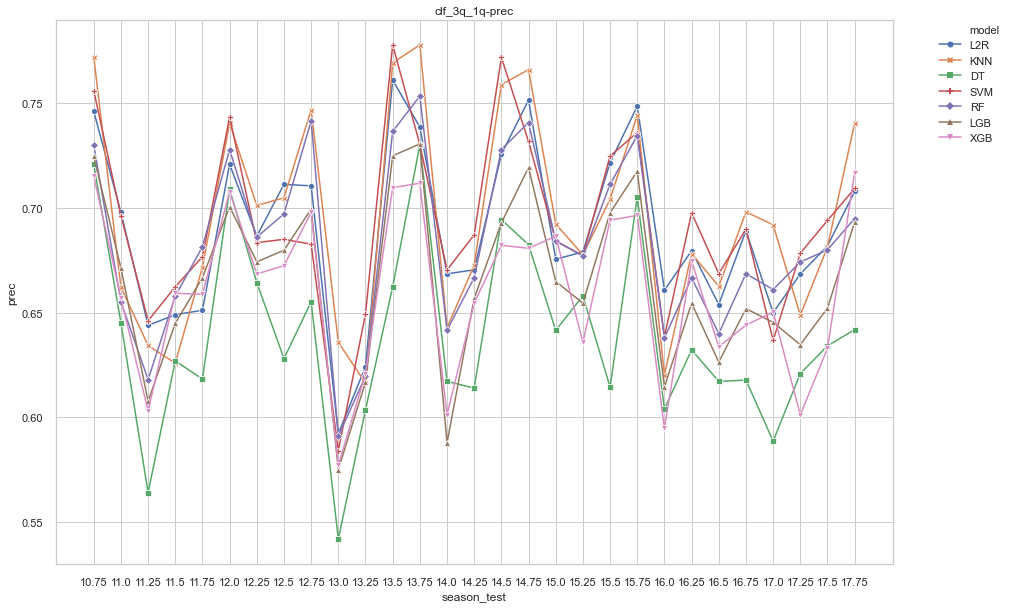

In [520]:
#### Visualize experiments results
name, res = get_result_by(experiment_name)
plot_results(name, res, figsize=(15, 10))

In [521]:
utils.folds_to_df(folds, train_seasons, test_seasons)

train_seasons  train_samples_size test_seasons  test_samples_size
0    10.0-10.25-10.5                 807        10.75                270
1   10.25-10.5-10.75                 808         11.0                209
2    10.5-10.75-11.0                 748        11.25                210
3   10.75-11.0-11.25                 689         11.5                209
4    11.0-11.25-11.5                 628        11.75                210
5   11.25-11.5-11.75                 629         12.0                269
6    11.5-11.75-12.0                 688        12.25                270
7   11.75-12.0-12.25                 749         12.5                269
8    12.0-12.25-12.5                 808        12.75                270
9   12.25-12.5-12.75                 809         13.0                269
10   12.5-12.75-13.0                 808        13.25                269
11  12.75-13.0-13.25                 808         13.5                269
12   13.0-13.25-13.5                 807        13.75                269
13  13.25-13.5-13.75                 807         14.0                268
14   13.5-13.75-14.0                 806        14.25                269
15  13.75-14.0-14.25                 806         14.5                269
16   14.0-14.25-14.5                 806        14.75                269
17  14.25-14.5-14.75                 807         15.0                269
18   14.5-14.75-15.0                 807        15.25                269
19  14.75-15.0-15.25                 807         15.5                269
20   15.0-15.25-15.5                 807        15.75                269
21  15.25-15.5-15.75                 807         16.0                268
22   15.5-15.75-16.0                 806        16.25                269
23  15.75-16.0-16.25                 806         16.5                269
24   16.0-16.25-16.5                 806        16.75                269
25  16.25-16.5-16.75                 807         17.0                269
26   16.5-16.75-17.0                 807        17.25                269
27  16.75-17.0-17.25                 807         17.5                269
28   17.0-17.25-17.5                 807        17.75                270

### Experiment train: 3q ; test: 1q ; skip: 3q

In [522]:
experiment_name = f"{exp_prefix}3q_1q_3s"

In [523]:
del_result_by(experiment_name)

folds, train_seasons, test_seasons = sscv.quarter_split(train_size=3, test_size=1, skip_size=3)
params = (experiment_name, models, folds, train_seasons, test_seasons, X, y)
names, results = utils_exp.run_experiment(*params)
results_total.append((experiment_name, results))

print_prettier_exp_results(experiment_name)

Running experiment clf_3q_1q_3s
Done


exp_name model  prec_mean  prec_std  bal_acc_mean  bal_acc_std
57  clf_3q_1q_3s   KNN   0.739660  0.034659      0.663043     0.029671
60  clf_3q_1q_3s    RF   0.718125  0.029664      0.650158     0.033327
56  clf_3q_1q_3s   L2R   0.717921  0.033027      0.656043     0.034061
59  clf_3q_1q_3s   SVM   0.714050  0.026921      0.647143     0.026584
61  clf_3q_1q_3s   LGB   0.700401  0.026647      0.627661     0.033138
62  clf_3q_1q_3s   XGB   0.690202  0.025258      0.613881     0.036498
58  clf_3q_1q_3s    DT   0.671453  0.041772      0.582573     0.043655

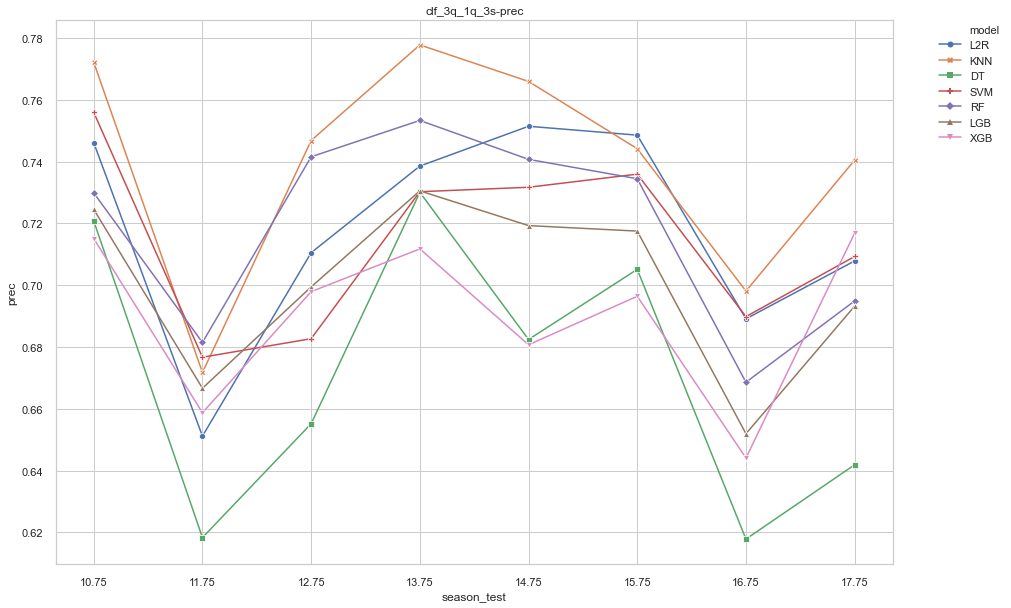

In [524]:
#### Visualize experiments results
name, res = get_result_by(experiment_name)
plot_results(name, res, figsize=(15, 10))

In [525]:
utils.folds_to_df(folds, train_seasons, test_seasons)

train_seasons  train_samples_size test_seasons  test_samples_size
0  10.0-10.25-10.5                 807        10.75                270
1  11.0-11.25-11.5                 628        11.75                210
2  12.0-12.25-12.5                 808        12.75                270
3  13.0-13.25-13.5                 807        13.75                269
4  14.0-14.25-14.5                 806        14.75                269
5  15.0-15.25-15.5                 807        15.75                269
6  16.0-16.25-16.5                 806        16.75                269
7  17.0-17.25-17.5                 807        17.75                270

### Experiment train: 4q ; test: 2q

In [526]:
experiment_name = f"{exp_prefix}4q_2q"

In [527]:
del_result_by(experiment_name)

folds, train_seasons, test_seasons = sscv.quarter_split(train_size=4, test_size=2)
params = (experiment_name, models, folds, train_seasons, test_seasons, X, y)
names, results = utils_exp.run_experiment(*params)
results_total.append((experiment_name, results))

print_prettier_exp_results(experiment_name)

Running experiment clf_4q_2q
Done


exp_name model  prec_mean  prec_std  bal_acc_mean  bal_acc_std
63  clf_4q_2q   L2R   0.690971  0.037510      0.645948     0.028073
66  clf_4q_2q   SVM   0.689033  0.044929      0.640940     0.030071
64  clf_4q_2q   KNN   0.683843  0.045020      0.624047     0.029048
67  clf_4q_2q    RF   0.682052  0.041034      0.630789     0.030171
69  clf_4q_2q   XGB   0.668391  0.036500      0.609562     0.024570
68  clf_4q_2q   LGB   0.662298  0.035329      0.603394     0.023959
65  clf_4q_2q    DT   0.648167  0.034026      0.574866     0.024771

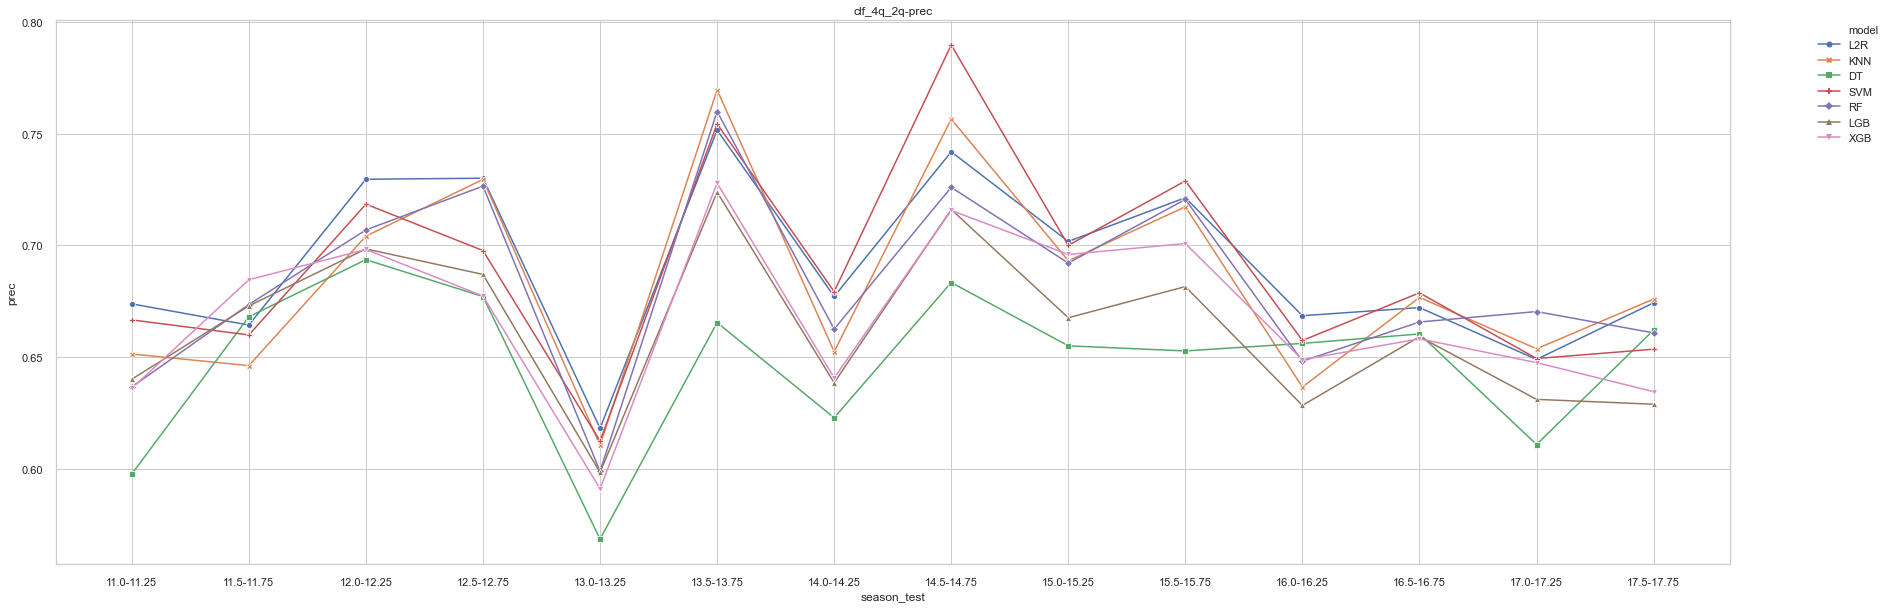

In [528]:
#### Visualize experiments results
name, res = get_result_by(experiment_name)
plot_results(name, res, figsize=(30,10))

In [529]:
utils.folds_to_df(folds, train_seasons, test_seasons)

train_seasons  train_samples_size test_seasons  test_samples_size
0   10.0-10.25-10.5-10.75                1077   11.0-11.25                419
1   10.5-10.75-11.0-11.25                 958   11.5-11.75                419
2   11.0-11.25-11.5-11.75                 838   12.0-12.25                539
3   11.5-11.75-12.0-12.25                 958   12.5-12.75                539
4   12.0-12.25-12.5-12.75                1078   13.0-13.25                538
5   12.5-12.75-13.0-13.25                1077   13.5-13.75                538
6   13.0-13.25-13.5-13.75                1076   14.0-14.25                537
7   13.5-13.75-14.0-14.25                1075   14.5-14.75                538
8   14.0-14.25-14.5-14.75                1075   15.0-15.25                538
9   14.5-14.75-15.0-15.25                1076   15.5-15.75                538
10  15.0-15.25-15.5-15.75                1076   16.0-16.25                537
11  15.5-15.75-16.0-16.25                1075   16.5-16.75                538
12  16.0-16.25-16.5-16.75                1075   17.0-17.25                538
13  16.5-16.75-17.0-17.25                1076   17.5-17.75                539

### Experiment remove first 2q ; train: 4q ; test: 2q

In [530]:
experiment_name = f"{exp_prefix}4q_2q_r2q"

In [531]:
del_result_by(experiment_name)

folds, train_seasons, test_seasons = sscv.quarter_split(train_size=4, test_size=2, remove_quarters=[0.25, 0.50])
params = (experiment_name, models, folds, train_seasons, test_seasons, X, y)
names, results = utils_exp.run_experiment(*params)
results_total.append((experiment_name, results))

print_prettier_exp_results(experiment_name)

Running experiment clf_4q_2q_r2q
Done


exp_name model  prec_mean  prec_std  bal_acc_mean  bal_acc_std
73  clf_4q_2q_r2q   SVM   0.706520  0.039289      0.648567     0.029217
74  clf_4q_2q_r2q    RF   0.705563  0.015026      0.645422     0.023430
70  clf_4q_2q_r2q   L2R   0.703957  0.027136      0.648346     0.026681
71  clf_4q_2q_r2q   KNN   0.702521  0.025962      0.635195     0.022852
76  clf_4q_2q_r2q   XGB   0.695153  0.018079      0.630548     0.017739
75  clf_4q_2q_r2q   LGB   0.694963  0.016141      0.630074     0.020902
72  clf_4q_2q_r2q    DT   0.653261  0.015834      0.567405     0.019671

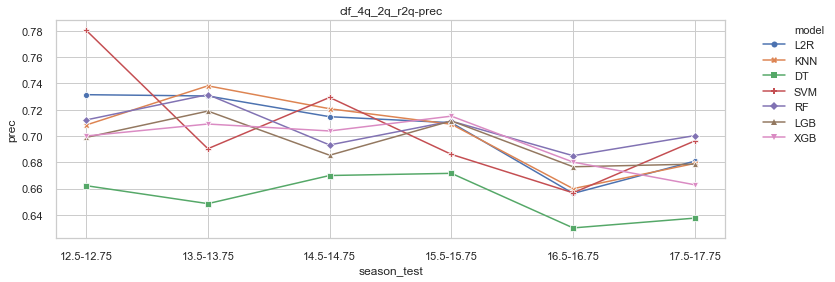

In [532]:
#### Visualize experiments results
name, res = get_result_by(experiment_name)
plot_results(name, res, figsize=(12,4))

In [533]:
utils.folds_to_df(folds, train_seasons, test_seasons)

train_seasons  train_samples_size test_seasons  test_samples_size
0  10.5-10.75-11.5-11.75                 958   12.5-12.75                539
1  11.5-11.75-12.5-12.75                 958   13.5-13.75                538
2  12.5-12.75-13.5-13.75                1077   14.5-14.75                538
3  13.5-13.75-14.5-14.75                1076   15.5-15.75                538
4  14.5-14.75-15.5-15.75                1076   16.5-16.75                538
5  15.5-15.75-16.5-16.75                1076   17.5-17.75                539

### Experiments comparison

In [534]:
utils.serialize_object(exp_group_name, utils_exp.exp_results)

In [535]:
utils_exp.exp_results = utils.deserialize_object(exp_group_name)
exp_df = get_results_df()

In [536]:
ba_df = exp_df[['exp_name', 'model',
       'prec_mean', 'prec_std', 'bal_acc_mean', 'bal_acc_std']]

In [537]:
#show_qgrid(exp_df)
qgrid_widget = qgrid.show_grid(exp_df, show_toolbar=True , grid_options={'forceFitColumns': False, 'defaultColumnWidth': 200})
qgrid_widget

QgridWidget(grid_options={'fullWidthRows': True, 'syncColumnCellResize': True, 'forceFitColumns': False, 'defa…

In [538]:
ba_df.sort_values(
    by=["prec_mean"]
    , ascending=False)[:6].reset_index().drop(labels=["index"], axis=1)

exp_name model  prec_mean  prec_std  bal_acc_mean  bal_acc_std
0   clf_3q_1q_3s   KNN   0.739660  0.034659      0.663043     0.029671
1   clf_3q_1q_3s    RF   0.718125  0.029664      0.650158     0.033327
2   clf_3q_1q_3s   L2R   0.717921  0.033027      0.656043     0.034061
3   clf_3q_1q_3s   SVM   0.714050  0.026921      0.647143     0.026584
4  clf_4q_2q_r2q   SVM   0.706520  0.039289      0.648567     0.029217
5  clf_4q_2q_r2q    RF   0.705563  0.015026      0.645422     0.023430

### Plot experiment results

In [539]:
utils.serialize_object("results", utils_exp.exp_results)
utils.serialize_object("results_total", results_total)

#### Balance Accuracy

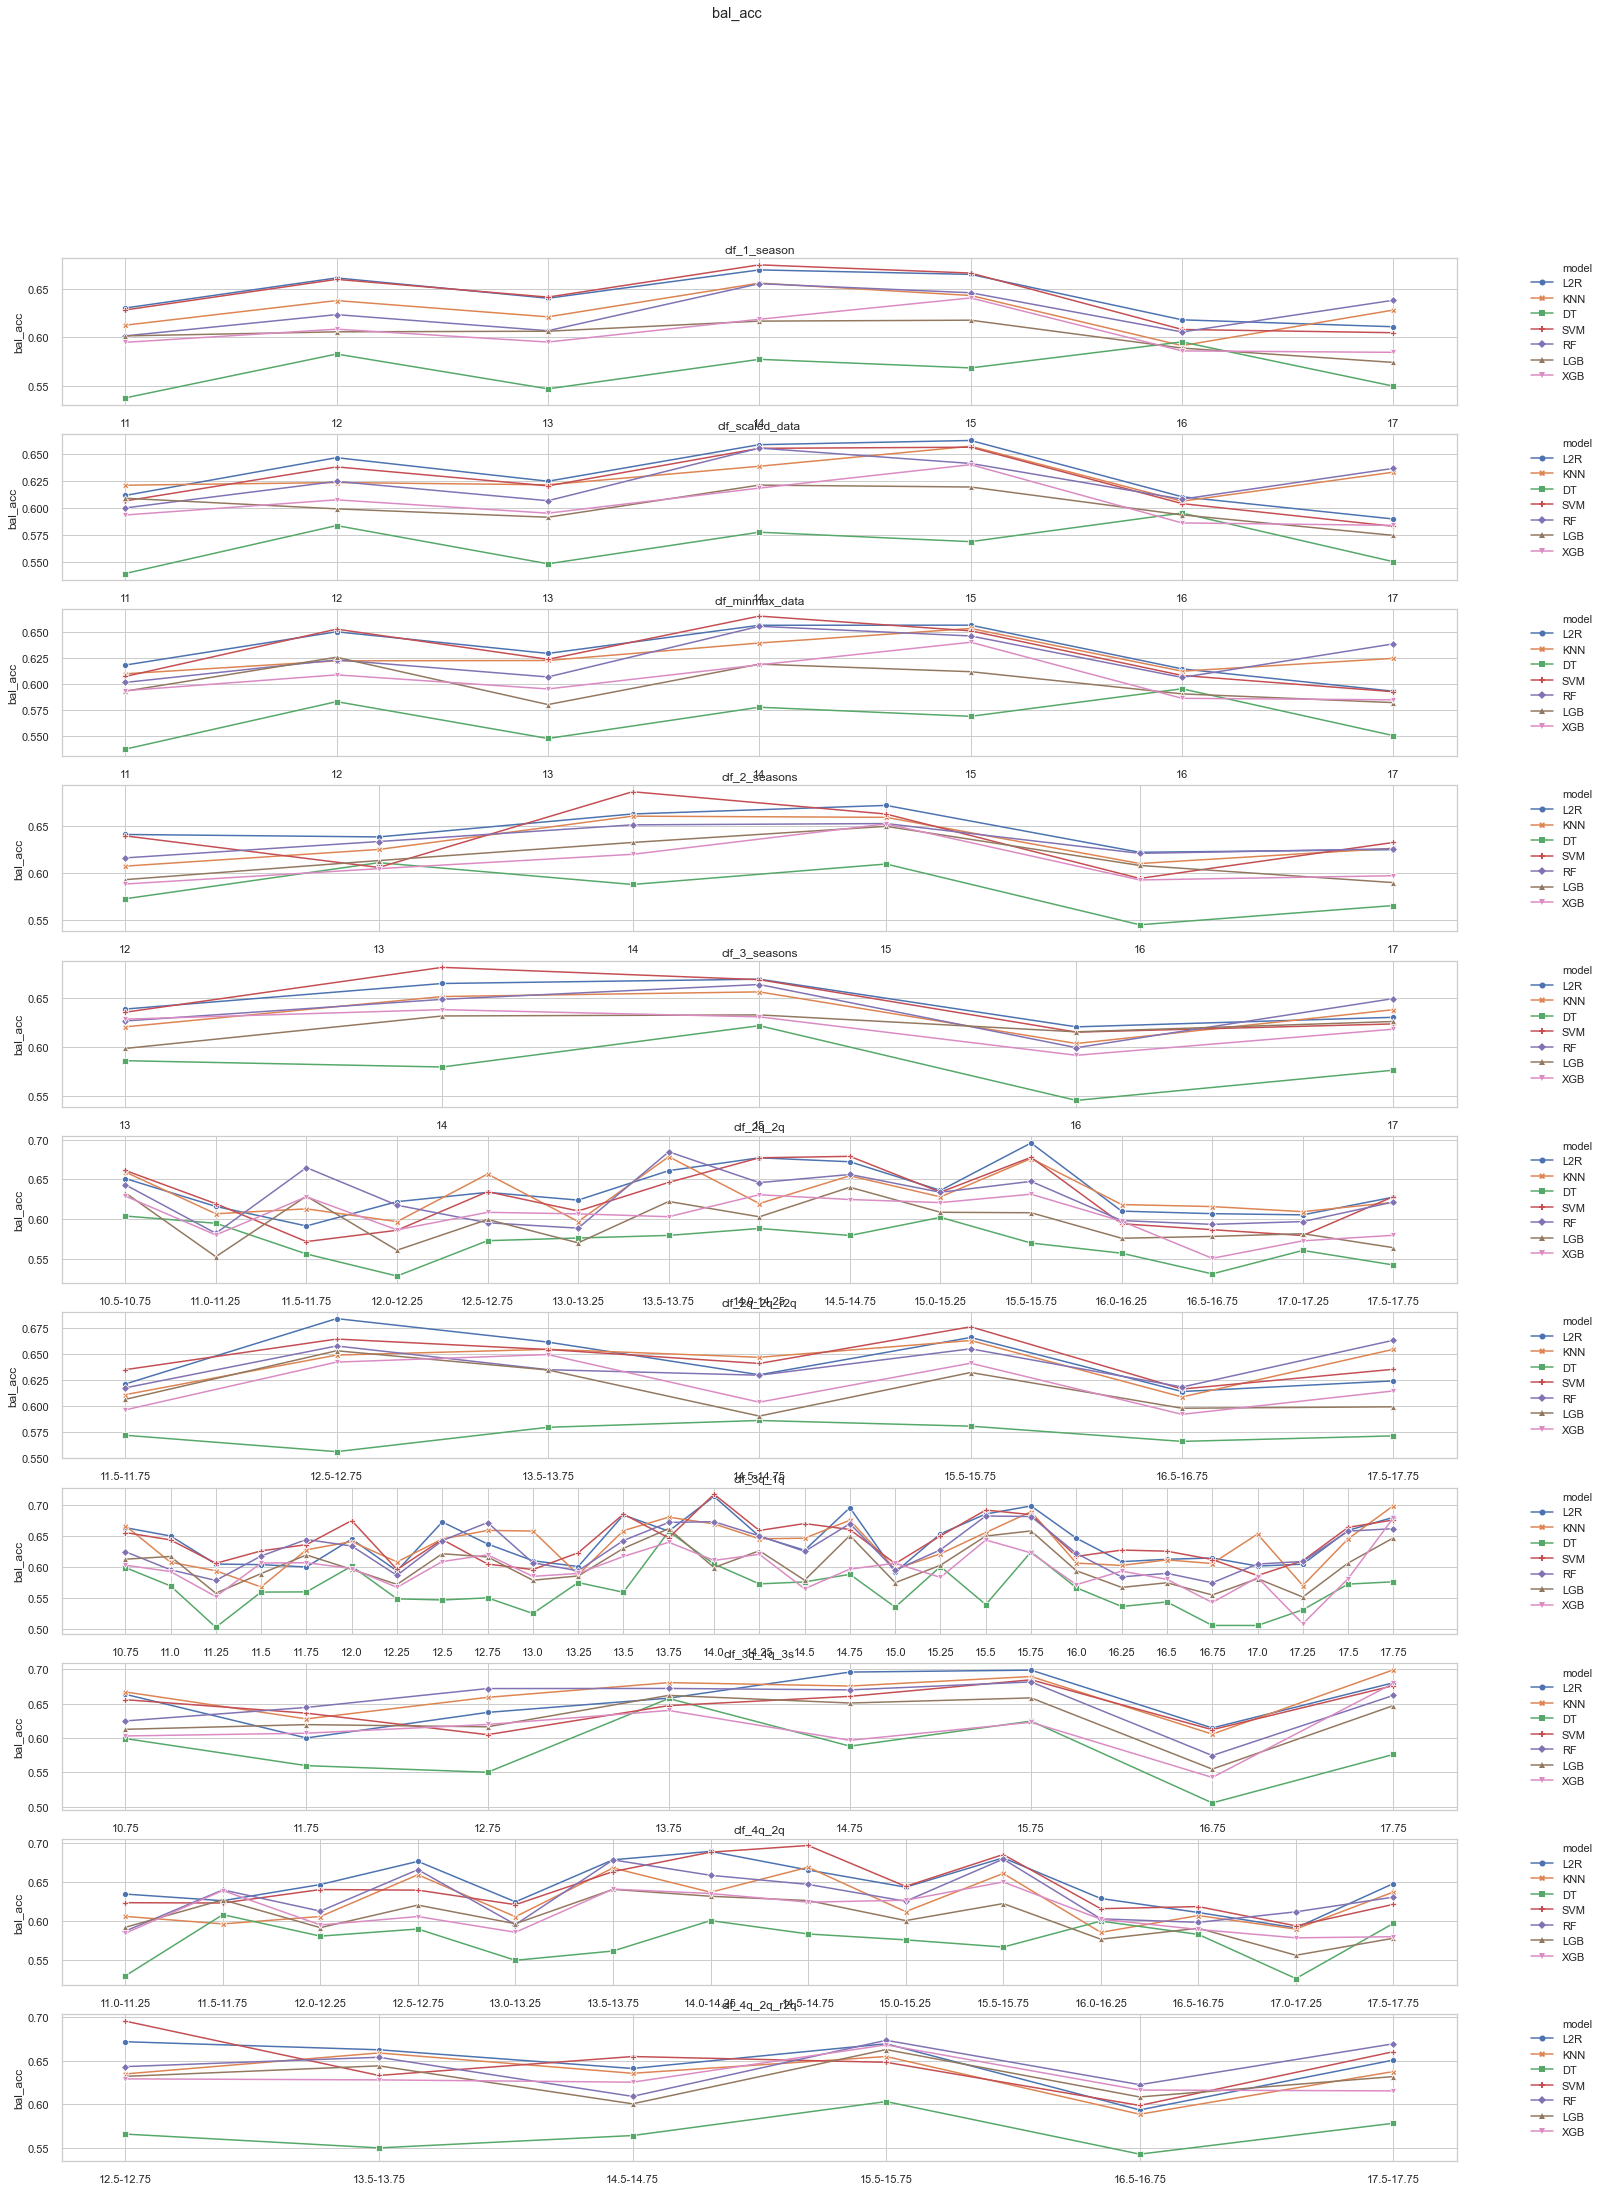

In [540]:
utils.plot_to_compare_experiments(
    results_total,
    metric="bal_acc",
    figsize=(25, 35),
    use_pointplot=True
)

#### Precision

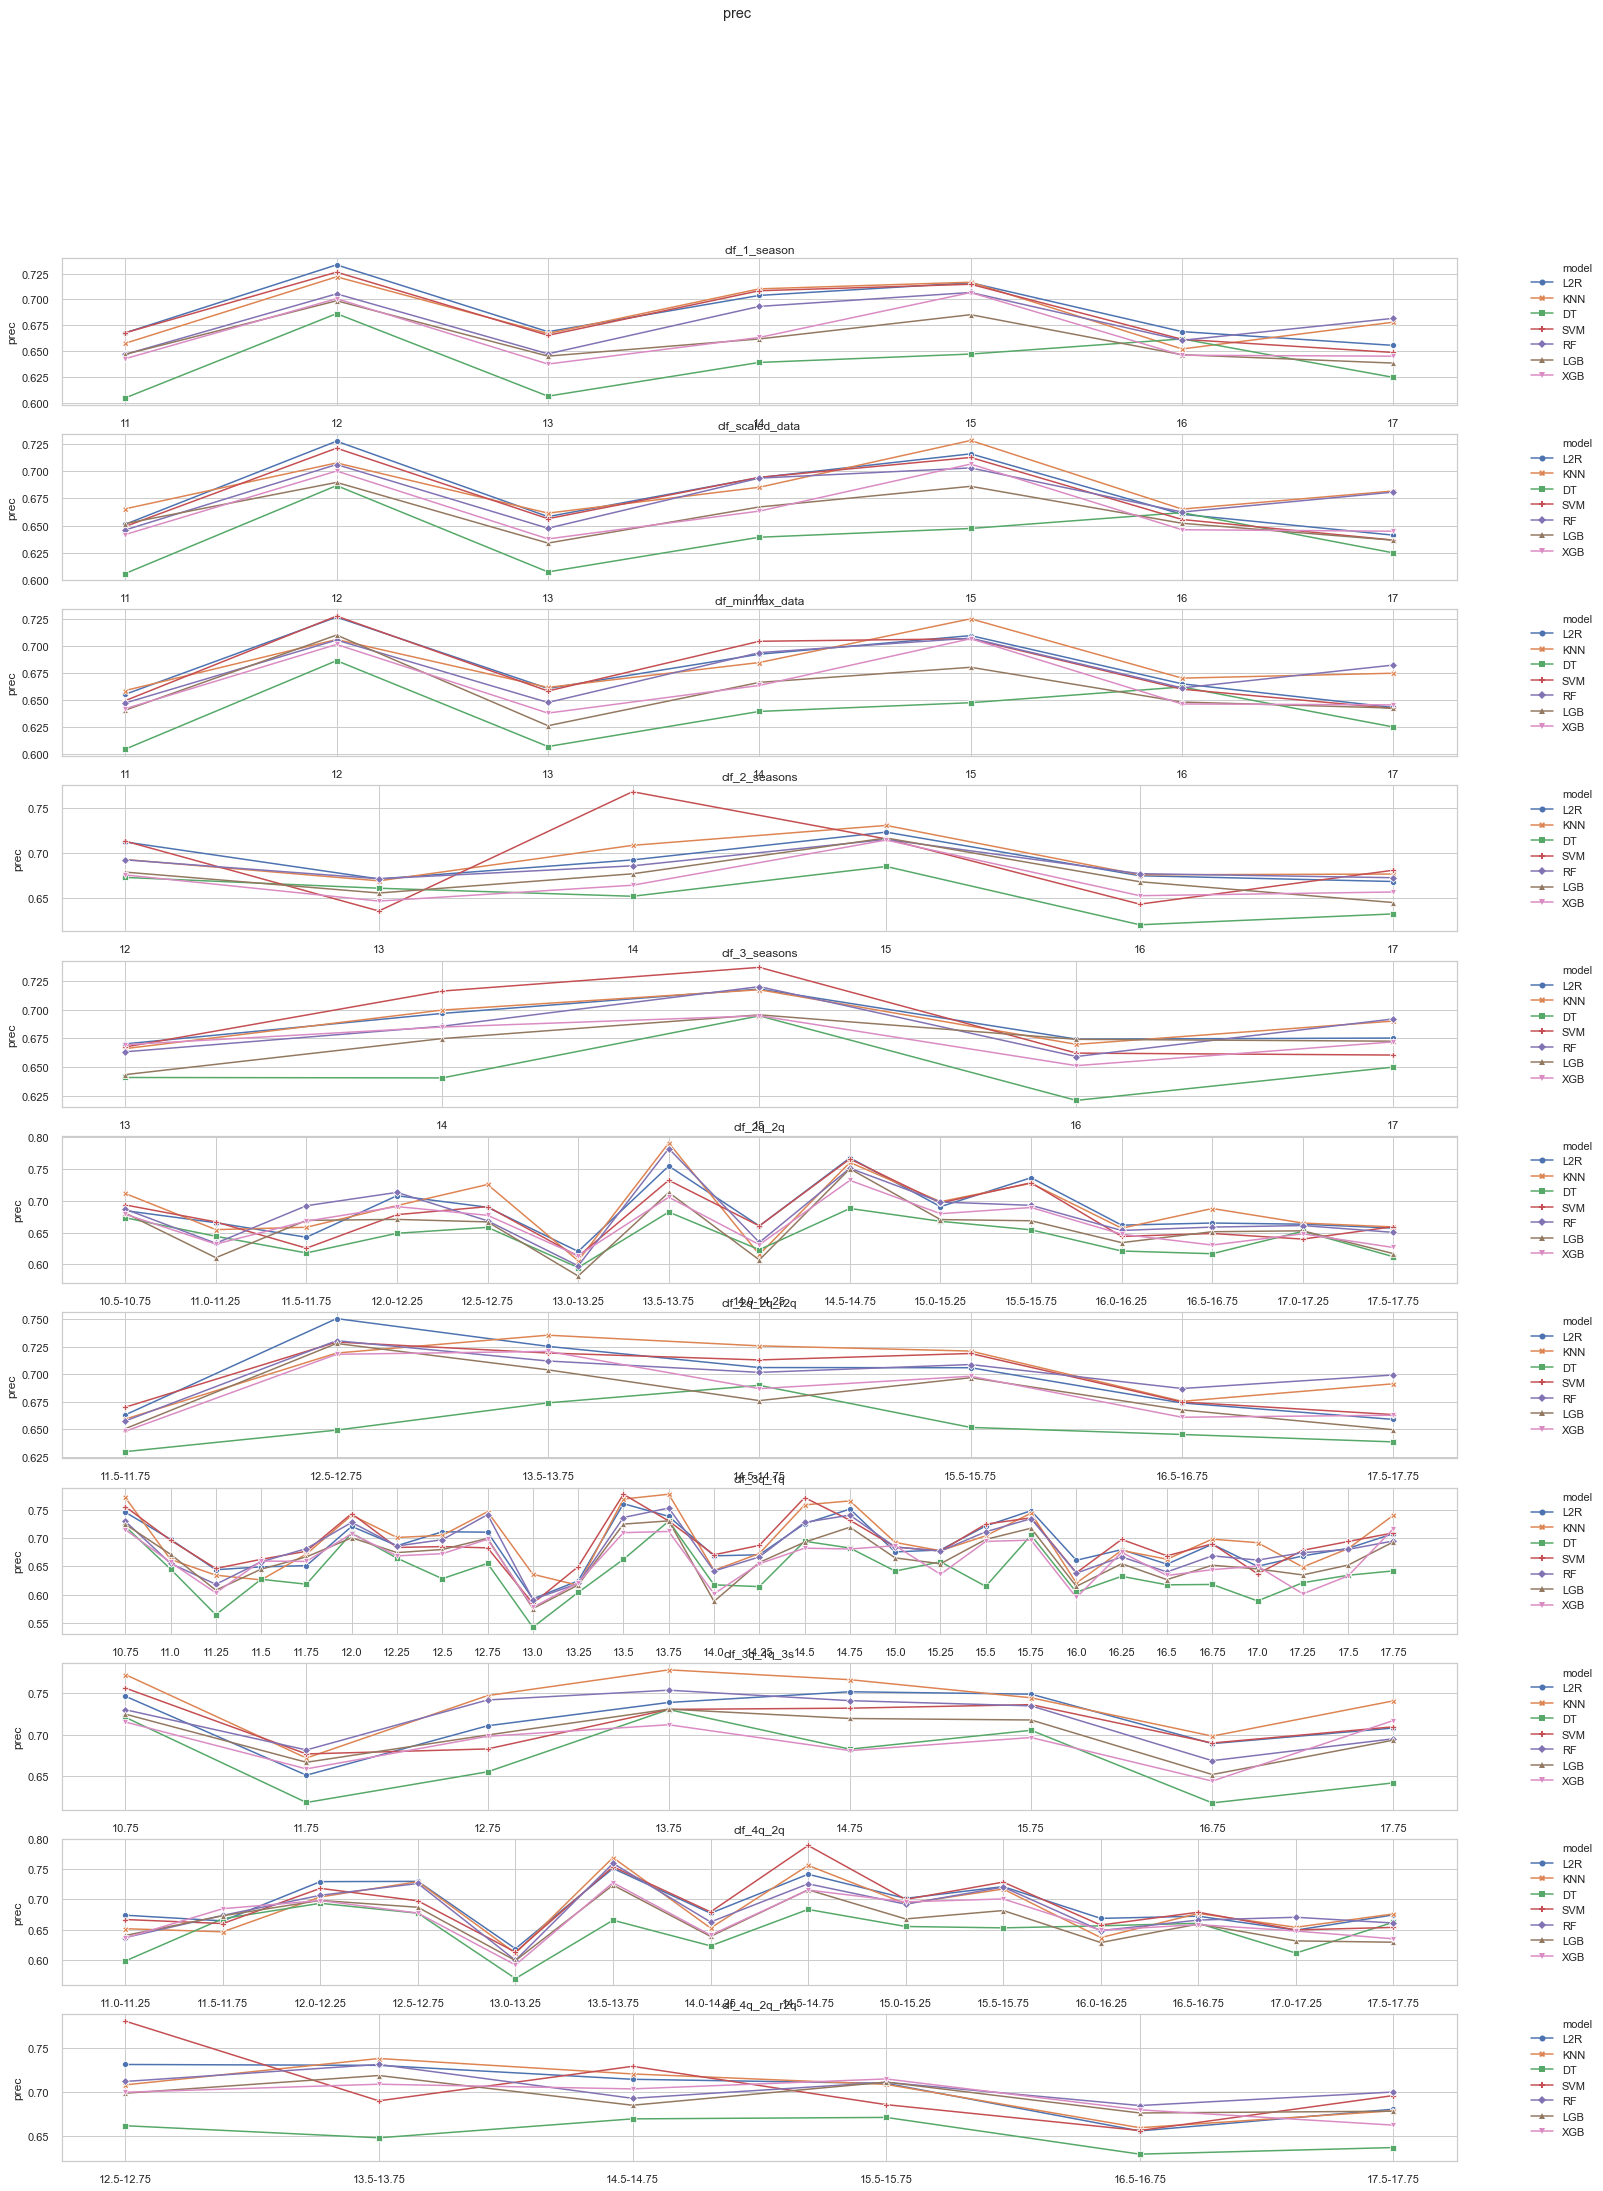

In [541]:
utils.plot_to_compare_experiments(
    results_total,
    metric="prec",
    figsize=(25, 35),
    use_pointplot=True
)

#### ROC AUC

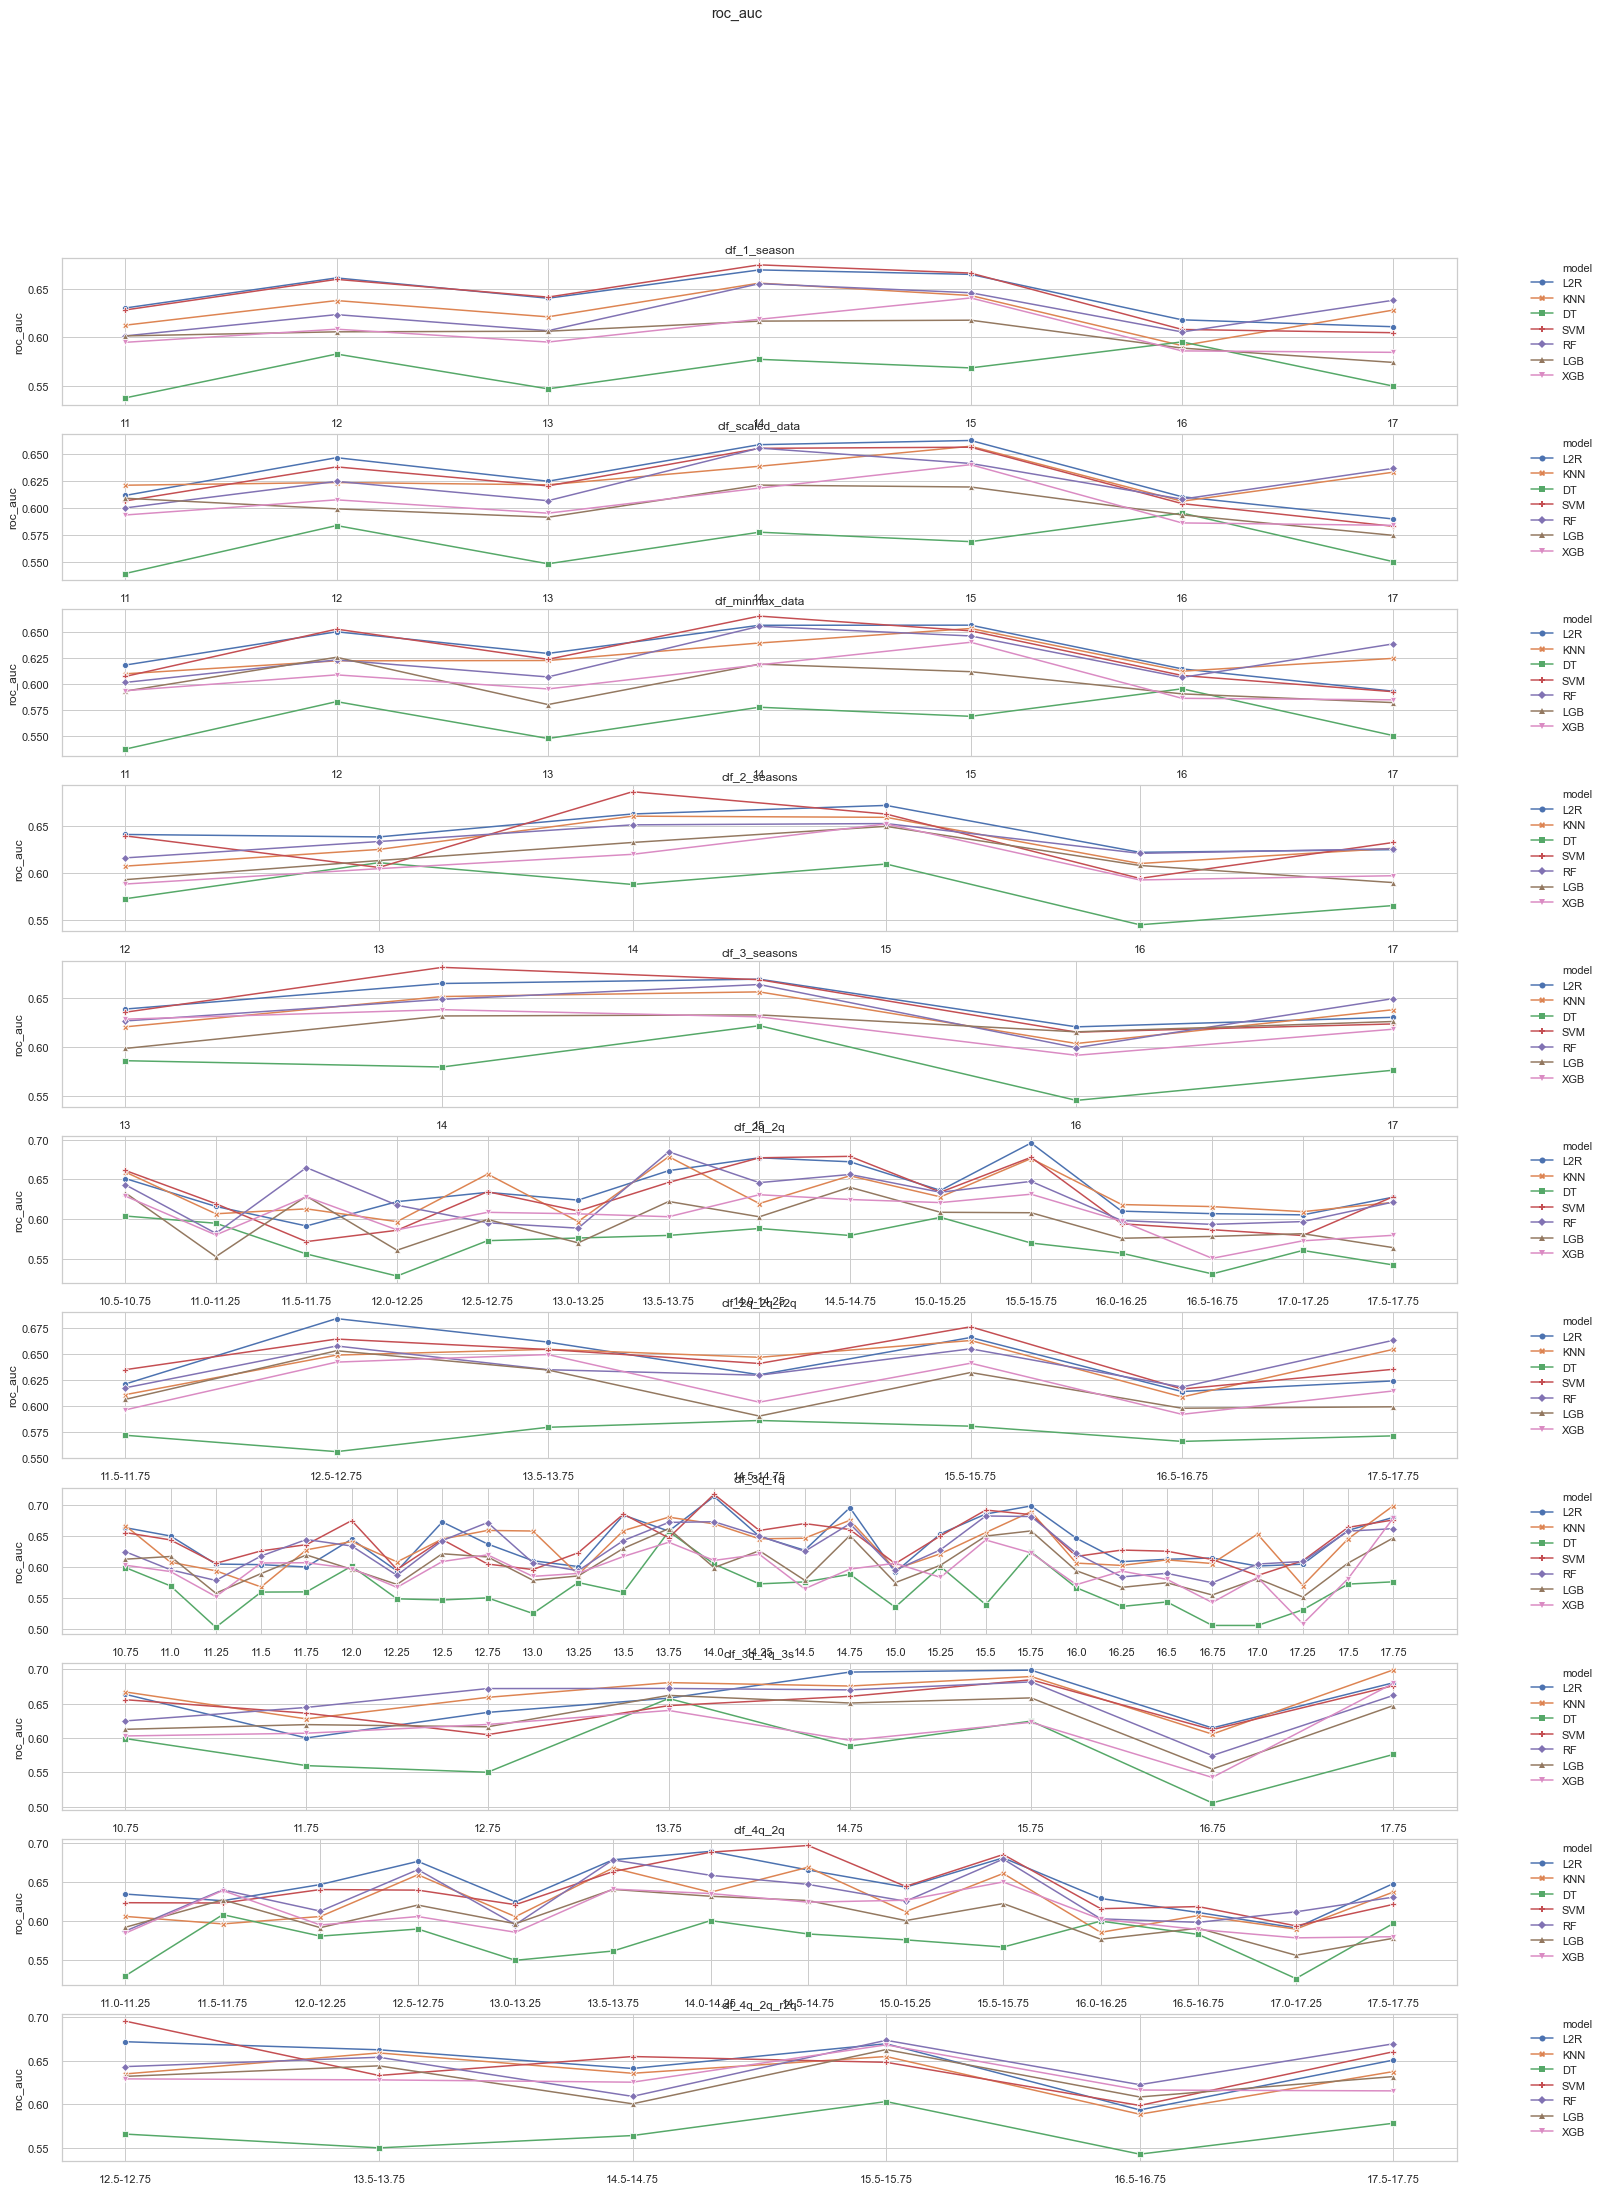

In [542]:
utils.plot_to_compare_experiments(
    results_total,
    metric="roc_auc",
    figsize=(25, 35),
    use_pointplot=True
)

### Optimization

#### Imports

In [489]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
import lightgbm as lgb
import xgboost as xgb

from sklearn.metrics import precision_score, \
        balanced_accuracy_score
from hyperopt import hp, fmin, tpe, STATUS_OK, Trials
from hpsklearn import HyperoptEstimator
import hpsklearn
from hyperopt.pyll import scope, as_apply
from hyperopt import SparkTrials, STATUS_OK

#### Dataset

In [18]:
op_df = season_games[(season_games.SEASON >= 2010) & (season_games.SEASON <= 2017)]

##### Seasons

In [19]:
op_df.SEASON.unique()

array([2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017])

##### Clean Data

In [20]:
print(op_df.shape)
op_df = op_df.dropna()
print(op_df.isnull().sum().sum())
print(op_df.isna().sum().sum())
print(op_df.shape)

(9599, 261)
0
0
(9461, 261)


#### setup

In [21]:
exp_prefix = "clf_"
#exp_group_name = "clf_experiments"
exp_group_name = "clf_op"
results_total = utils.deserialize_object(f'result_totals_{exp_group_name}', [])

op_models = utils_exp.get_clf_models()

op_sscv = utils.SeasonSeriesSplit(op_df)
op_df_sscv = op_sscv.get_df()
op_X = op_df_sscv[exp_X_columns]
op_y = op_df_sscv[TARGET]

#### Utils

In [22]:
def walk_forward_val_mean_score(input_model):
    metric_results = []
    for train_idx, test_idx in folds:
        X_train, X_test = X.loc[train_idx], X.loc[test_idx]
        y_train, y_test = y.loc[train_idx], y.loc[test_idx]
        y_true = y_test
        
        pipeline = Pipeline(steps=[
                ('model', input_model)])
        
        model = pipeline
        fit_info = pipeline.fit(X_train, y_train)
        y_pred = pipeline.predict(X_test)
        metric_results.append(balanced_accuracy_score(y_true, y_pred)) 

    return np.mean(metric_results)  


def walk_forward_sklearn(estim):
    metric_results = []
    for train_idx, test_idx in folds:
        X_train, X_test = X.loc[train_idx], X.loc[test_idx]
        y_train, y_test = y.loc[train_idx], y.loc[test_idx]
        y_true = y_test
        
        estim.fit(X_train, y_train)
        print(estim.score(X_test, y_test))
        print(estim.best_model())

#### Optimization

In [23]:
folds, train_seasons, test_seasons = op_sscv.split(train_size=2, test_size=1)

In [24]:
# name = 'clf'
# models = [
#     #hpsklearn.svc(name + '.SVM'),
#     #svc_linear
#     #hpsklearn.random_forest(name + '.RF'),
#     #hpsklearn.xgboost_classification(name + '.XGB'),
#     #hpsklearn.lightgbm_classification(name + '.LGB')
#     hpsklearn.svc_linear(name + 'SVM')
# ]


# estim = HyperoptEstimator(classifier=hp.choice('%s' % name, models),
#                           #preprocessing=hpsklearn.any_preprocessing('my_pre'),
#                           preprocessing=None,
#                           algo=tpe.suggest,
#                           max_evals=50,
#                           trial_timeout=120)



# for train_idx, test_idx in folds:
#     X_train, X_test = X.loc[train_idx], X.loc[test_idx]
#     y_train, y_test = y.loc[train_idx], y.loc[test_idx]
#     y_true = y_test
#     estim.fit(X_train, y_train)
#     estim.score(X_test, y_test)

# print(estim.best_model())

#### LGB

In [31]:
space = {
    'max_depth': scope.int(hp.uniform('max_depth', 1, 11)),
    'num_leaves': scope.int(hp.uniform('num_leaves', 2, 121)),
    'learning_rate': hp.loguniform('learning_rate', np.log(0.0001), np.log(0.5)) - 0.0001,
    'n_estimators': scope.int(hp.quniform('n_estimators', 100, 6000, 200)),
    'gamma': hp.loguniform('gamma', np.log(0.0001), np.log(5)) - 0.0001,
    'min_child_weight': scope.int(hp.loguniform('min_child_weight', np.log(1), np.log(100))),
    'subsample': hp.uniform('subsample', 0.5, 1),
    'colsample_bytree': hp.uniform('colsample_bytree', 0.5, 1),
    'colsample_bylevel': hp.uniform('colsample_bylevel', 0.5, 1),
    'reg_alpha': hp.loguniform('reg_alpha', np.log(0.0001), np.log(1)) - 0.0001,
    'reg_lambda': hp.loguniform('reg_lambda', np.log(1), np.log(4)),
    #boosting_type: hp.choice(name, ['gbdt', 'dart', 'goss'])
    'boosting_type': hp.choice('boosting_type', ['gbdt'])
}

default_hiperparameters = {
    'objective': 'binary',
    #'random_state': 0
}

def objective(space):
    print(space)
    hiperparameters = {**default_hiperparameters, **space}
    model = lgb.LGBMClassifier(
        **hiperparameters
    )

    accuracy = walk_forward_val_mean_score(model)

    return {'loss': -accuracy, 'status': STATUS_OK }

spark_trials = SparkTrials(parallelism=4)
#trials = Trials()
best = fmin(
        fn=objective,
        space=space,
        algo=tpe.suggest,
        max_evals=150,
        trials=spark_trials,
        rstate=np.random.RandomState(seed=0),
        return_argmin=False
    )
best

100%|██████████| 150/150 [1:57:28<00:00, 46.99s/trial, best loss: -0.7318679777757647] 


Total Trials: 150: 150 succeeded, 0 failed, 0 cancelled.


{'boosting_type': 'gbdt',
 'colsample_bylevel': 0.6108224915520017,
 'colsample_bytree': 0.7991125058203208,
 'gamma': 0.0012626451163248382,
 'learning_rate': 0.0018545119732252533,
 'max_depth': 2,
 'min_child_weight': 2,
 'n_estimators': 3800,
 'num_leaves': 87,
 'reg_alpha': 0.2835687543880991,
 'reg_lambda': 1.2786968649636916,
 'subsample': 0.5660499077502952}

#### Experiment

In [39]:

op_model = [
#     ('SVM', SVC(C=0.012697068361313206, cache_size=512, degree=1, gamma='auto',
#     kernel='linear', max_iter=54006698.0, random_state=4,
#     tol=8.876549929680088e-05)),
#     ("LGB", lgb.LGBMClassifier(boosting_type='dart', colsample_bytree=0.5774517052371843,
#                learning_rate=0.001088309810177423, max_delta_step=0,
#                max_depth=9, min_child_weight=22, n_estimators=3200, n_jobs=1,
#                num_leaves=19, objective='binary',
#                reg_alpha=0.0009920138640525102, reg_lambda=2.593449218886441,
#                scale_pos_weight=1, seed=3, subsample=0.980626212446999)),
    ('LGB', lgb.LGBMClassifier(
        **{'boosting_type': 'gbdt',
 'colsample_bylevel': 0.7911287100076613,
 'colsample_bytree': 0.8603649524735973,
 'gamma': 4.43302024049316,
 'learning_rate': 0.0009592641656631401,
 'max_depth': 3,
 'min_child_weight': 17,
 'n_estimators': 4000,
 'num_leaves': 72,
 'reg_alpha': 1.0620929521387056e-05,
 'reg_lambda': 1.3493051864867296,
 'subsample': 0.9099643557200597}
    )),
    ('LGB2', lgb.LGBMClassifier(
        **{'boosting_type': 'gbdt',
 'colsample_bylevel': 0.7729132785100075,
 'colsample_bytree': 0.8237696281830607,
 'gamma': 0.02767717987305845,
 'learning_rate': 0.004301947480128295,
 'max_depth': 5,
 'min_child_weight': 4,
 'n_estimators': 1400,
 'num_leaves': 101,
 'reg_alpha': 0.0004447330199770369,
 'reg_lambda': 1.1974372235637603,
 'subsample': 0.6524249725030407}
    )),
    ('LGB3', lgb.LGBMClassifier(**
    {'boosting_type': 'gbdt',
 'colsample_bylevel': 0.6108224915520017,
 'colsample_bytree': 0.7991125058203208,
 'gamma': 0.0012626451163248382,
 'learning_rate': 0.0018545119732252533,
 'max_depth': 2,
 'min_child_weight': 2,
 'n_estimators': 3800,
 'num_leaves': 87,
 'reg_alpha': 0.2835687543880991,
 'reg_lambda': 1.2786968649636916,
 'subsample': 0.5660499077502952})),
    ("XGB", xgb.XGBClassifier(base_score=0.5, booster='gbtree',
              colsample_bylevel=0.9274316569938598, colsample_bynode=1,
              colsample_bytree=0.768350297812703, gamma=0.275559851080226,
              gpu_id=-1, importance_type='gain', interaction_constraints='',
              learning_rate=0.00383884756104703, max_delta_step=0, max_depth=2,
              min_child_weight=3, monotone_constraints='()',
              n_estimators=5600, n_jobs=1, num_parallel_tree=1, random_state=3,
              reg_alpha=1.6862525411636347e-05, reg_lambda=1.976163318531772,
              scale_pos_weight=1, seed=3, subsample=0.9990805503135648,
              tree_method='exact', validate_parameters=1, verbosity=None)),
    
    ("XGB2", xgb.XGBClassifier(**{'colsample_bylevel': 0.6377999154047157,
 'colsample_bytree': 0.9842293615322797,
 'gamma': 0.0005531486918297421,
 'learning_rate': 0.0007474569779455549,
 'max_depth': 10,
 'min_child_weight': 6,
 'n_estimators': 4600,
 'reg_alpha': 0.011708580861937797,
 'reg_lambda': 2.0311282671384228,
 'subsample': 0.5680268128073964})
    )
]

model_names = ['LGB', 'XGB']

In [40]:
experiment_name = f"{exp_prefix}2_seasons_op"
del_result_by(experiment_name)

folds, train_seasons, test_seasons = sscv.split(train_size=2, test_size=1)
params = (experiment_name, op_model, folds, train_seasons, test_seasons, X, y)
names, results = utils_exp.run_experiment(*params)
results_total.append((experiment_name, results))

print_prettier_exp_results(experiment_name[:-3], metric='prec', filter_val= names)
print_prettier_exp_results(experiment_name)
# 11	clf_2_seasons	SVM	0.760366	0.011854	0.728416	0.012863
    # 8	clf_2_seasons	L2R	0.760026	0.011737	0.728800	0.014623
# 12	clf_2_seasons	RF	0.758332	0.011720	0.724693	0.010767
# 13	clf_2_seasons	XGB	0.748373	0.005121	0.706205	0.006501
# 14	clf_2_seasons	LGB	0.743551	0.005716	0.702446	0.006115

#XGB	0.74998	0.00996	0.721646	


Running experiment clf_2_seasons_op
Done


Empty DataFrame
Columns: [exp_name, model, prec_mean, prec_std, bal_acc_mean, bal_acc_std]
Index: []

exp_name model  prec_mean  prec_std  bal_acc_mean  bal_acc_std
2  clf_2_seasons_op  LGB3   0.764682  0.008933      0.731868     0.011893
0  clf_2_seasons_op   LGB   0.764012  0.010939      0.731917     0.012155
1  clf_2_seasons_op  LGB2   0.763515  0.008504      0.728363     0.008645
3  clf_2_seasons_op   XGB   0.759969  0.010427      0.724662     0.010840
4  clf_2_seasons_op  XGB2   0.759758  0.012012      0.724763     0.011260

TypeError: cannot unpack non-iterable NoneType object

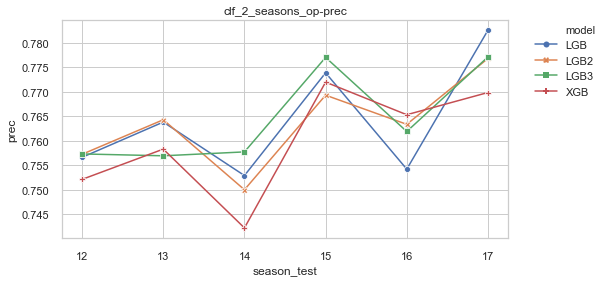

In [37]:
name, res = get_result_by(experiment_name)
plot_results(name, res, figsize=(8,4))
name, res = get_result_by(experiment_name[:-3])

res = [x for x in res if x['model'][0] in model_names] 
plot_results(name[:-3], res, figsize=(8,4))

### Final validation

#### Dataset

In [15]:
fv_df = season_games[(season_games.SEASON >= 2016)]

##### Seasons

In [16]:
fv_df.SEASON.unique()

array([2016, 2017, 2018, 2019])

##### clean data

In [17]:
print(fv_df.shape)
fv_df = fv_df.dropna()
print(fv_df.isnull().sum().sum())
print(fv_df.isna().sum().sum())
print(fv_df.shape)

(4749, 261)
0
0
(4685, 261)


#### setup

In [18]:
exp_prefix = "clf_"
#exp_group_name = "clf_experiments"
exp_group_name = "clf_final_validation"
results_total = utils.deserialize_object(f'result_totals_{exp_group_name}', [])

fv_models = utils_exp.get_clf_models()

fv_sscv = utils.SeasonSeriesSplit(fv_df)
fv_df_sscv = fv_sscv.get_df()
fv_X = fv_df_sscv[exp_X_columns]
fv_y = fv_df_sscv[TARGET]

#### experiment

In [19]:
experiment_name = f"{exp_prefix}2_seasons_fv"

In [20]:
del_result_by(experiment_name)

folds, train_seasons, test_seasons = fv_sscv.split(train_size=2, test_size=1)
params = (experiment_name, fv_models, folds, train_seasons, test_seasons, fv_X, fv_y)
names, results = utils_exp.run_experiment(*params)
results_total.append((experiment_name, results))

print_prettier_exp_results(experiment_name)

Running experiment clf_2_seasons_fv
Done


exp_name model  prec_mean  prec_std  bal_acc_mean  bal_acc_std
4  clf_2_seasons_fv    RF   0.762396  0.033825      0.738084     0.020561
3  clf_2_seasons_fv   SVM   0.761851  0.029544      0.745272     0.016139
0  clf_2_seasons_fv   L2R   0.757738  0.028254      0.742014     0.013661
6  clf_2_seasons_fv   LGB   0.749895  0.025701      0.716310     0.007497
5  clf_2_seasons_fv   XGB   0.741749  0.025189      0.711492     0.009271
2  clf_2_seasons_fv    DT   0.700006  0.008087      0.650257     0.012661
1  clf_2_seasons_fv   KNN   0.659587  0.024073      0.613094     0.007160

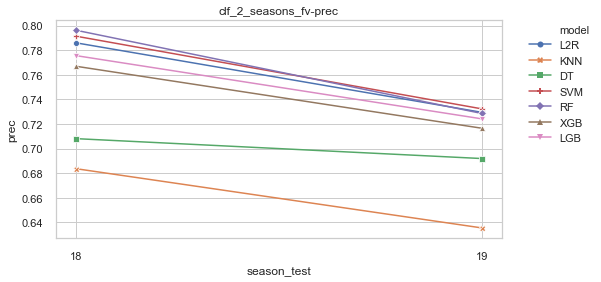

In [21]:
#### Visualize experiments results
name, res = get_result_by(experiment_name)
plot_results(name, res, figsize=(8,4))